In [46]:
import pandas as pd
import numpy as np  
import os 
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from typing import Optional, Sequence, Any, Dict

In [47]:
os.chdir((Path.home() / "wdpath.txt").read_text().strip())
os.getcwd()

'/Users/canderson/Documents/school/CPBS7602-class/assignment-03'

In [48]:
with open("processed-data/001-dat-dict.pkl",'rb') as f:
    dat_dict = pickle.load(f)

In [49]:
type(dat_dict)
len(dat_dict)
dat_dict.keys()
for key, value in dat_dict.items():
    print(f"{key}: {value.shape}")

counts: (56200, 17382)
rowData: (56200, 2)
colData: (17382, 67)


In [50]:
with open("processed-data/001-dat-dict.pkl",'rb') as f:
    dat_dict = pickle.load(f)

In [51]:
type(dat_dict)
len(dat_dict)
dat_dict.keys()
for key, value in dat_dict.items():
    print(f"{key}: {value.shape}")

counts: (56200, 17382)
rowData: (56200, 2)
colData: (17382, 67)


In [52]:
for col in dat_dict["colData"]:
    print(col)
    print(dat_dict["colData"][col].unique()[:10])

SAMPID
['GTEX-1117F-0226-SM-5GZZ7' 'GTEX-1117F-0426-SM-5EGHI'
 'GTEX-1117F-0526-SM-5EGHJ' 'GTEX-1117F-0626-SM-5N9CS'
 'GTEX-1117F-0726-SM-5GIEN' 'GTEX-1117F-1326-SM-5EGHH'
 'GTEX-1117F-2426-SM-5EGGH' 'GTEX-1117F-2526-SM-5GZY6'
 'GTEX-1117F-2826-SM-5GZXL' 'GTEX-1117F-2926-SM-5GZYI']
SMATSSCR
[ 0.  1.  2. nan  3.]
SMCENTER
['B1' 'B1, A1' 'C1' 'C1, A1' 'C1, B1, A1' nan 'D1' 'D1, A1']
SMPTHNTS
['2 pieces, ~15% vessel stroma, rep delineated'
 '2 pieces, !5% fibrous connective tissue, delineated (rep)'
 '2 pieces, clean, Monckebeg medial sclerosis, rep delineated'
 '2 pieces, up to 4mm aderent fat/nerve/vessel, delineated'
 '2 pieces, no abnormalities'
 '2 pieces, diffuse mesothelial hyperplasia; ~10% vessel/fibrous tissue (delineated)'
 '1 piece mymetrial smooth muscle as in corresonding -25 block'
 '6  pieces, squamous epithelium is ~ 2-3% thickness, partially sloughing'
 '2 pieces, fibrocystic changes, rep ductal/lobular elements delineated'
 '6 pieces, minimal fat, squamous epithelium is

## Filter Data

In [53]:

def filter_se(
    SE: Dict[str, Any],
    margin: Optional[int] = None,
    indices: Optional[Sequence[int]] = None
) -> Dict[str, Any]:
    """
    Filter a SingleCellExperiment-style dictionary.

    Parameters
    ----------
    SE : dict
        A data dict with 'counts', 'rowData', 'colData'
    margin : int
        0 = filter rows (genes); 
        1 = filter columns (samples)
    indices : int or bool sequence
        Indices to keep.

    Returns
    -------
    dict
        Filtered SE dictionary.
    """
    ...

    if margin == 0:
        # filter genes (rows)
        return {
            # "logcounts": SE['logcounts'].iloc[indices, :],
            "counts": SE['counts'].iloc[indices, :],
            "rowData": SE['rowData'].iloc[indices, :],
            "colData": SE['colData']
        }

    elif margin == 1:
        # filter samples (columns)
        return {
            # "logcounts": SE['logcounts'].iloc[:, indices],
            "counts": SE['counts'].iloc[:, indices],
            "rowData": SE['rowData'],  # unchanged
            "colData": SE['colData'].iloc[indices, :]
        }

    else:
        raise ValueError("margin must be 0 (rows/genes) or 1 (columns/samples)")

### Select top tissues

In [54]:
top_tiss = pd.DataFrame(dat_dict["colData"]['SMTS'].value_counts()).sort_values(by = "count", ascending = False).head(10).index
print(top_tiss)

Index(['Brain', 'Skin', 'Esophagus', 'Blood Vessel', 'Adipose Tissue', 'Blood',
       'Heart', 'Muscle', 'Colon', 'Thyroid'],
      dtype='object', name='SMTS')


In [55]:

tiss_inds = dat_dict["colData"]['SMTS'].isin(top_tiss).values
dat_dict = filter_se(dat_dict, 1, tiss_inds)

In [56]:
print(dat_dict['colData'].shape)
print(dat_dict['counts'].shape)

(12460, 67)
(56200, 12460)



### Select top 5000 most variable genes

In [57]:
# first exclude missy genes
## gene missing proportions
zero_sum = (dat_dict['counts']==0).sum(axis=1).values
zero_prop = zero_sum / (dat_dict['counts'].shape[1])
pd.Series(zero_prop).describe()

count    56200.000000
mean         0.482141
std          0.414476
min          0.000000
25%          0.005698
50%          0.501324
75%          0.930819
max          1.000000
dtype: float64

In [58]:
x, bins = np.histogram(zero_prop)

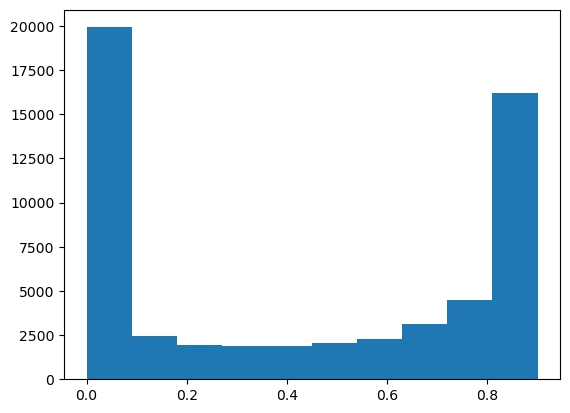

In [59]:
plt.figure()
plt.hist(bins[:-1],weights =  x)
plt.show()

In [60]:
# select for genes with < 60% 0s
non_missy_genes = zero_prop<.6
dat_dict = filter_se(dat_dict, margin = 0, indices = non_missy_genes)

In [61]:
# Compute variance for each gene 
variance = dat_dict["counts"].var(axis=1)

In [62]:
x, y = range(len(variance.values)), sorted(np.log1p(variance))

In [63]:
top_y = y[-5000:]
len(top_y)
is_top = np.zeros(len(y), dtype = bool)
is_top[-5000:]= True

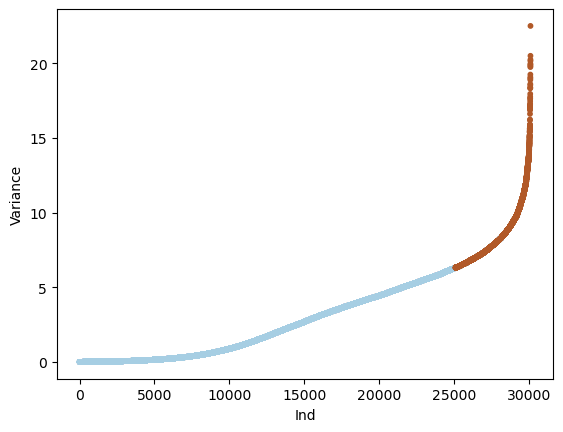

In [64]:
plt.figure()
p1 = plt.scatter(
    x, y, c=is_top, s=10, cmap=plt.cm.Paired
)
plt.xlabel("Ind")
plt.ylabel("Variance")
plt.show()

In [65]:
# select top genes
dat_dict = filter_se(dat_dict, 0, is_top)

### Standardize data

In [66]:
# lognormalize
## colSums
libsize = dat_dict['counts'].sum(axis=0) # sum across rows= colsums
# sum normalize columns and multiply by scaling factor so each sample sum is same
norm = dat_dict['counts'].div(libsize, axis=1) * 10_000
# log normalize
lognorm = np.log1p(norm)

In [67]:
# standardize 
## gene rowmeans
mean = lognorm.mean(axis=1) # axis 1 = across columns
## rowSds
std = lognorm.std(axis=1,  ddof=1)   
## centered and scaled
Z = lognorm.sub(mean, axis=0).div(std, axis=0)

In [68]:
dat_dict["logcounts"]= Z

In [69]:
print("Saving...")
with(open("processed-data/002-dat-dict.pkl", 'wb') as f ):
    pickle.dump(dat_dict, f)
print("Done")

Saving...
Done
